### Modelling the Galactic LMXB distribution

In [79]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import astropy.units as u
import astropy.coordinates as coord 
from astropy.utils.console import ProgressBar
import healpy as hp
%matplotlib notebook

We follow https://ui.adsabs.harvard.edu/abs/2019MNRAS.484...19J and use https://ui.adsabs.harvard.edu/abs/2002A%26A...391..923G/abstract to construct a function which provides probabilistic samples of LMXB positions and distances.  Grimm+02 has a typo for the disk distribution; we use the correct version from https://ui.adsabs.harvard.edu/abs/1998MNRAS.294..429D/abstract.

In [2]:
density_convert = (1*u.parsec**-3).to(u.kpc**-3.)

In [3]:
def rho_bulge(r, z, rho0_bulge=1.9789*1e9, r0=1.0, q=0.6, gamma=1.8, rt=1.9):
    """Bulge density model from Grimm et al. 2002 (Eqn. 4)
    
    Parameters
    ----------
    r : float
        distance from the Galactic center (kpc)
    z : float
        distance perpendicular to the Galactic Plane (kpc)
    
    Returns
    -------
    density in solar masses per cubic kpc
    
    """
    
    return rho0_bulge * (np.sqrt(r**2. + z**2./q**2.)/r0)**(-1.*gamma) * np.exp(-1. * (r**2. + z**2./q**2.)/rt**2.)

def rho_disk(r, z, rho0_disk=1.313415*1e9, rm=6.5, rd=3.5, rz=0.410):
    """Disk density model from Grimm et al. 2002 (Eqn. 5).  
    
    Note a typo in the Grimm+02 paper; we include the correct version from Dehnen & Binney (1998)
    
    Parameters
    ----------
    r : float
        distance from the Galactic center (kpc)
    z : float
        distance perpendicular to the Galactic Plane (kpc)
    
    Returns
    -------
    density in solar masses per cubic kpc
    
    """
    
    return rho0_disk * np.exp(-1.*rm/rd - r/rd - np.abs(z)/rz)

def mass_disk(rho0_disk=1.313415*1e9, rm=6.5, rd=3.5, rz=0.410):
    """Integrated mass of disk from Dehnen & Binney (1998) eqn. 2
    
    Parameters
    ----------
    
    Returns
    -------
    density in solar masses
    
    """
    from scipy.special import kn
    
    sigma_d = rho0_disk * 2 * rz
    
    return 4*np.pi*sigma_d*rm*rd* kn(2,2*np.sqrt(rm/rd))

def rho_sphere(r, z, rho0_sphere=8.74*1e9, b=7.669, Re=2.8):
    """Disk density model from Grimm et al. 2002 (Eqn. 6)
    
    Parameters
    ----------
    r : float
        distance from the Galactic center (kpc)
    z : float
        distance perpendicular to the Galactic Plane (kpc)
    
    Returns
    -------
    density in solar masses per cubic kpc
    
    """
    
    R = np.sqrt(r**2. + z**2.)
    
    return rho0_sphere * np.exp(-1.*b*(R/Re)**(1/4)) / (R/Re)**(7/8)

Integrate numerically to get total masses.  Integrate in Galactocentric cylindrical coordinates from r ∊ 0,15 kpc, z ∊ -15,15 kpc

In [4]:
bulge_mass = 2*np.pi*integrate.dblquad(lambda r,z: r * rho_bulge(r,z), -15, 15, lambda r: 0, lambda r: 15)[0] 
disk_mass = 2*np.pi*integrate.dblquad(lambda r,z: r * rho_disk(r,z), -15, 15, lambda r: 0, lambda r: 15)[0]  
sphere_mass = 2*np.pi*integrate.dblquad(lambda r, z: r * rho_sphere(r,z), -15, 15, lambda r: 0, lambda r: 15)[0]  

Compare our numerical integral to the analytic value... not perfect

In [5]:
mass_disk()/disk_mass

2.2802363085057036

MJ reports that they could not reproduce the Grimm mass ratios with the provided normalizations.  We will follow them and use the [Picaurd & Robin 04](https://ui.adsabs.harvard.edu/abs/2004A%26A...428..891P/abstract) bulge mass estimate of 2.4e10 Msun, and adjust the other normalizations to match ratios of 2:1:0.3.

In [6]:
print(f'{bulge_mass:.2e} {disk_mass:.2e} {sphere_mass:.2e}')

2.40e+10 1.20e+10 3.60e+09


In [7]:
bulge_mass/disk_mass

1.9999954308634986

In [8]:
sphere_mass/disk_mass

0.2998325450823631

## load 3-d extinction maps and test them

we will use a fork of https://github.com/willclarkson/rubinCadenceScratchWIC

In [9]:
import sys
sys.path.append('/Users/ebellm/Eric/LSST/rubinCadenceScratchWIC/python')
import readExtinction

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
pathReddening = '/Users/ebellm/Eric/LSST/rubinCadenceScratchWIC/data/merged_ebv3d_nside64.fits'
print(pathReddening, os.access(pathReddening, os.R_OK))

/Users/ebellm/Eric/LSST/rubinCadenceScratchWIC/data/merged_ebv3d_nside64.fits True


In [12]:
ebv = readExtinction.ebv3d(pathReddening)
ebv.loadMap()

<IPython.core.display.Javascript object>


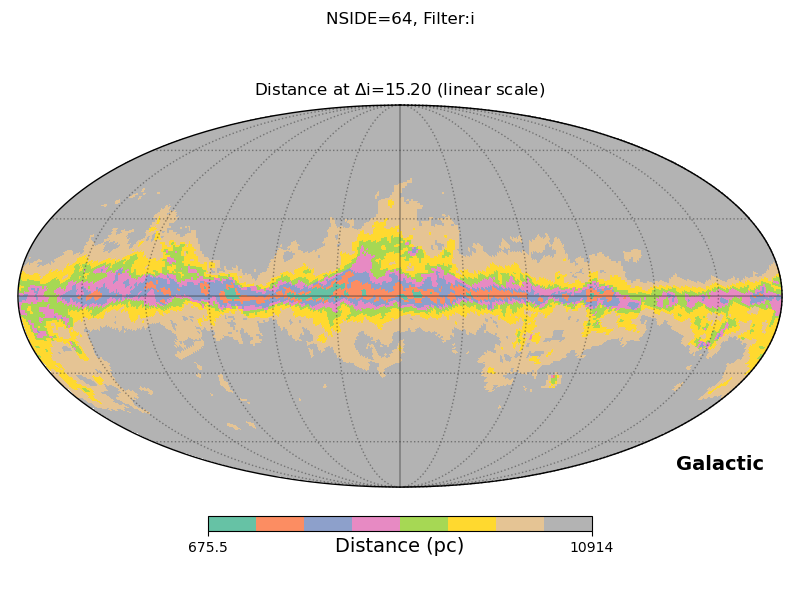

0.0 180.0 -180.0 180.0


In [13]:
readExtinction.testDeltamags('i', 15.2, cmap='Set2', pathMap=pathReddening)

<IPython.core.display.Javascript object>


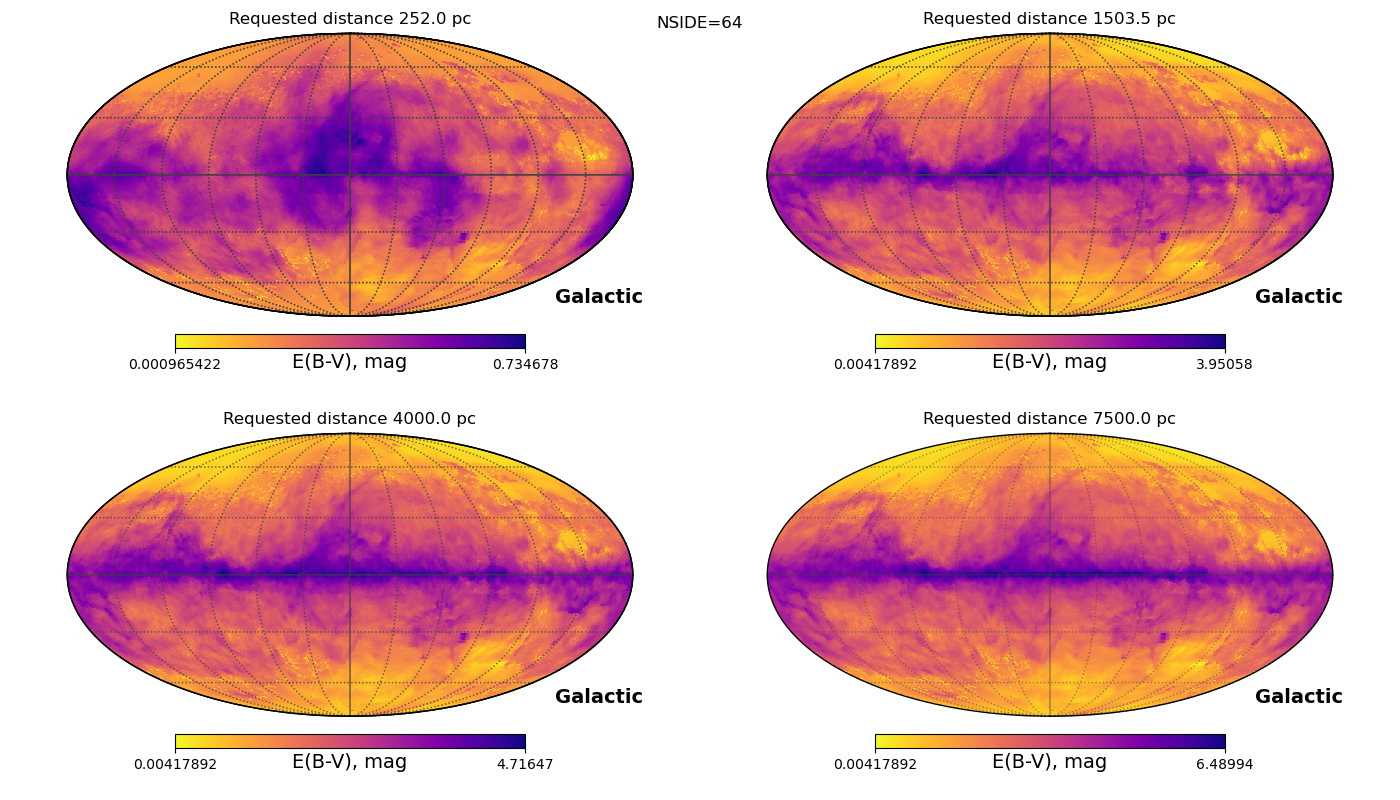

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


In [14]:
readExtinction.testReadExt(False, pathMap=pathReddening)

In [15]:
dir(ebv)

['R_x',
 'Verbose',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'calcDistmods',
 'dists',
 'dmods',
 'ebvs',
 'getDeltaMag',
 'getDistanceAtMag',
 'getEBVatSightline',
 'getInterpolatedProfile',
 'getMapNearestDist',
 'getMaxDistDeltaMag',
 'hdr',
 'hpids',
 'loadMap',
 'mask',
 'nested',
 'nside',
 'pathMap',
 'sfacs',
 'showDistanceInterval',
 'showMollview']

<IPython.core.display.Javascript object>


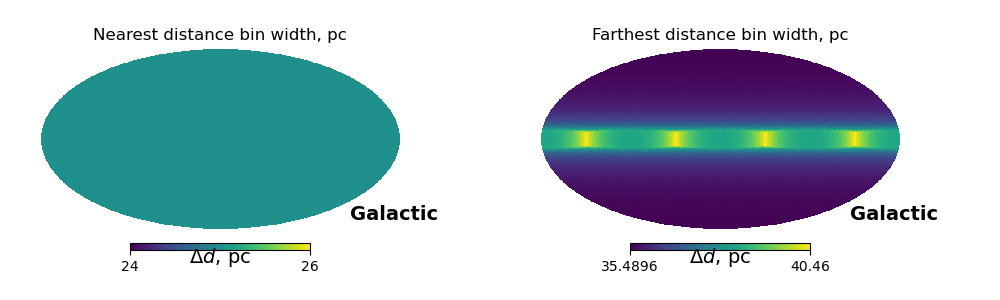

In [16]:
readExtinction.testShowDistresol( pathMap=pathReddening)

## determine distances to which we can see extincted K-stars.

We use the Johnson et al. 2019 absolute magnitudes for an LMXB with a K-type companion + disk in the LSST bands:

In [17]:
lmxb_abs_mag_r = 4.6
lmxb_abs_mags = {'u':lmxb_abs_mag_r + 4.14,
                 'g':lmxb_abs_mag_r + 3.24,
                 'r':lmxb_abs_mag_r,
                 'i':lmxb_abs_mag_r + 0.33,
                 'z':lmxb_abs_mag_r + 1.05,
                 'y':lmxb_abs_mag_r + 2.36
                 }

Next we load the limiting magnitudes per filter (taken from the Ivezic et al. 2019):

In [18]:
lsst_single_epoch_depth =  {'u':23.9,
                            'g':25.0,
                            'r':24.7,
                            'i':24.0,
                            'z':23.3,
                            'y':22.1
                            }

lsst_ten_year_depth =  {'u':26.1,
                        'g':27.4,
                        'r':27.5,
                        'i':26.8,
                        'z':26.1,
                        'y':24.9
                        }

The fiducial single-epoch depths are a compromise here: they are optimistic in the crowded regions of the Plane, but pessimistic when considering what can be achieved with forced photometry in data releases.  MAF has tools for assessing crowding but they are tied to specific OpSim runs in a way which is inconvenient for this purpose.

In [19]:
delta_mags = {}
for filt, M in lmxb_abs_mags.items():
    delta_mags[filt] = lsst_single_epoch_depth[filt] - M

In [20]:
delta_mags

{'u': 15.16,
 'g': 17.16,
 'r': 20.1,
 'i': 19.07,
 'z': 17.650000000000002,
 'y': 15.140000000000002}

<IPython.core.display.Javascript object>


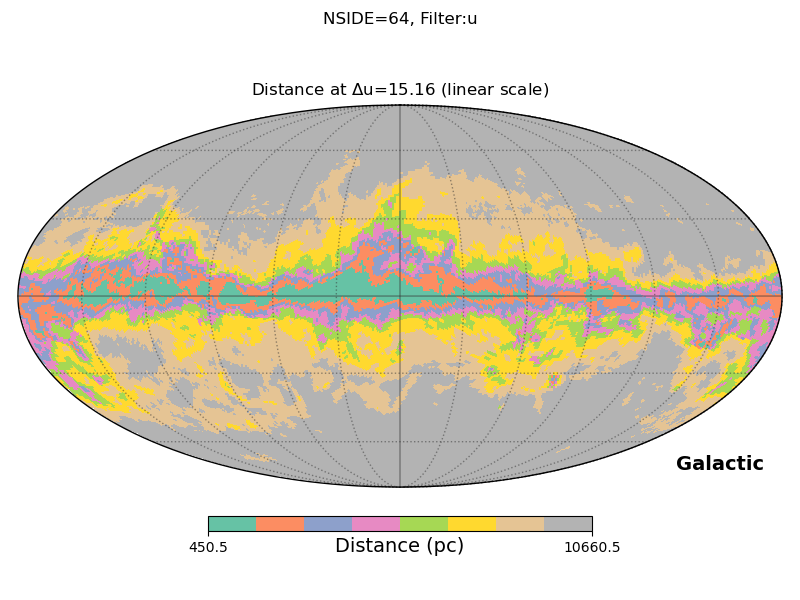

0.0 180.0 -180.0 180.0


<IPython.core.display.Javascript object>


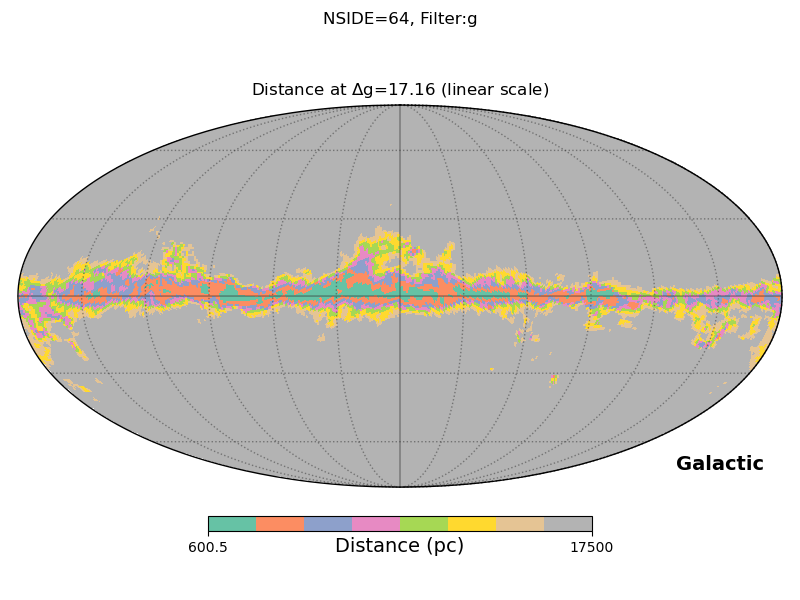

0.0 180.0 -180.0 180.0


<IPython.core.display.Javascript object>


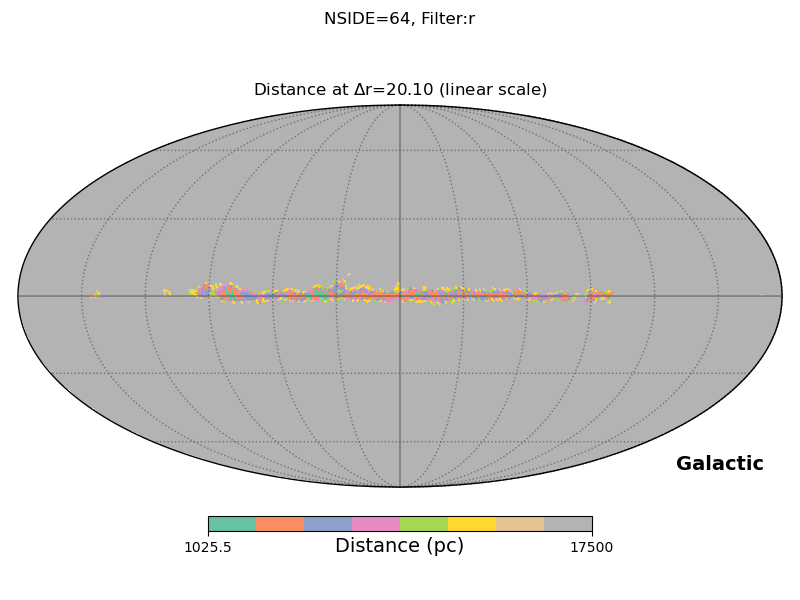

0.0 180.0 -180.0 180.0


<IPython.core.display.Javascript object>


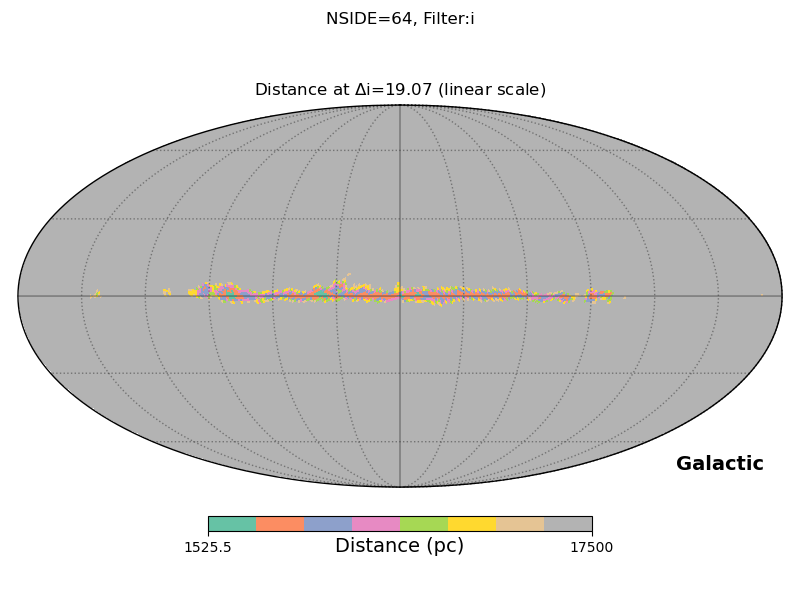

0.0 180.0 -180.0 180.0


<IPython.core.display.Javascript object>


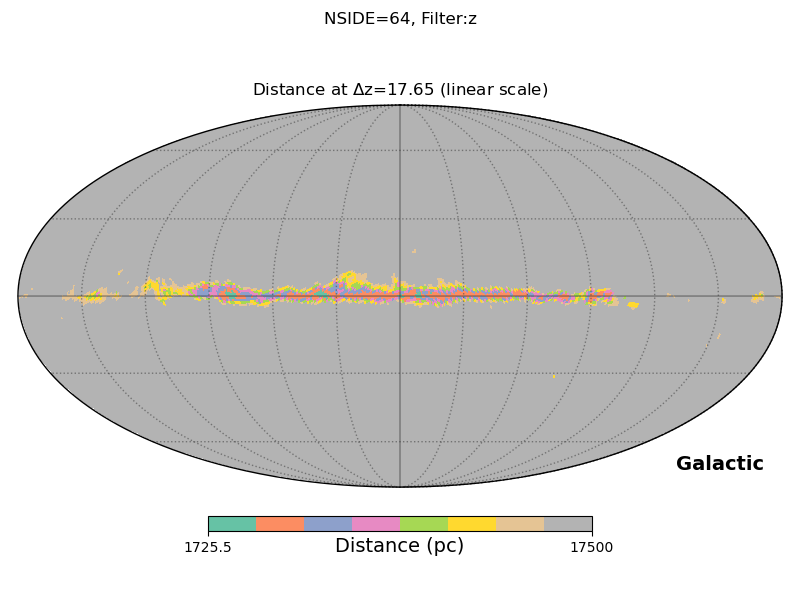

0.0 180.0 -180.0 180.0


<IPython.core.display.Javascript object>


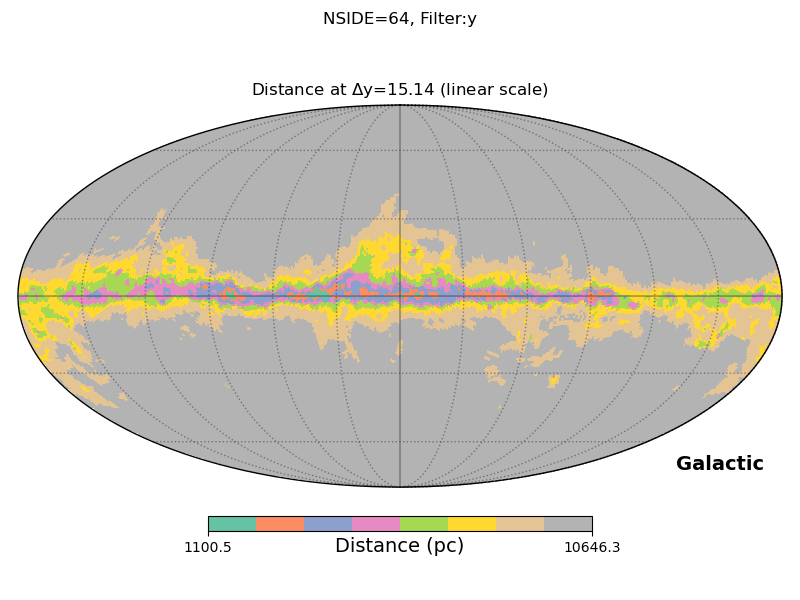

0.0 180.0 -180.0 180.0


In [23]:
distance_to_deltamag = {}
for filt, dmag in delta_mags.items():
    distance_to_deltamag[filt] = readExtinction.testDeltamags(filt, dmag, cmap='Set2', pathMap=pathReddening)

In [39]:
%pdb

Automatic pdb calling has been turned OFF


In [27]:
distance_to_deltamag['u']

array([6068.97385621, 5932.85      , 6902.76630435, ..., 7650.62527233,
       7542.78540305, 7261.99456522])

## Convert to relative spatial density in l, b for the TVS Plane metric

We want to integrate our Galaxy model of stellar density from 0 to the max distance we can see K-dwarfs in LSST single-epoch images, due to extinction.

Ideally the nearby distance would be the saturation limit but I expect this is a relatively minor effect.

<IPython.core.display.Javascript object>


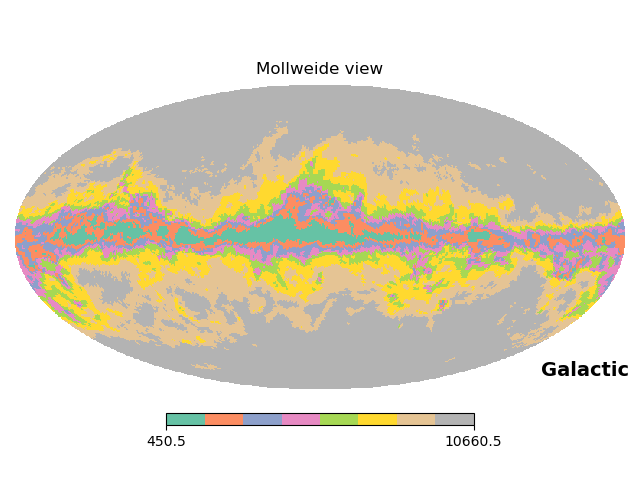

In [31]:
hp.mollview(distance_to_deltamag['u'], plt.figure(), coord=['C','G'],cmap='Set2')

In [40]:
# get the coordinates of the healpix distance maps we've made
NSIDE=64
hp_ra, hp_dec = hp.pix2ang(NSIDE,np.arange(hp.nside2npix(NSIDE)),lonlat=True)

<IPython.core.display.Javascript object>


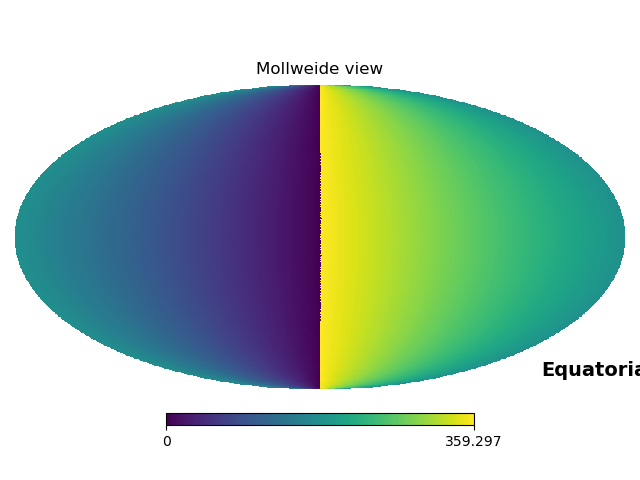

In [46]:
hp.mollview(hp_ra, plt.figure(), coord=['C'])

<IPython.core.display.Javascript object>


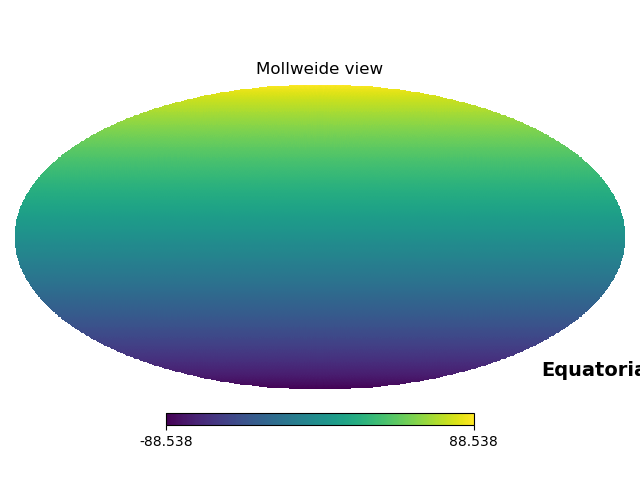

In [47]:
hp.mollview(hp_dec, plt.figure(), coord=['C'])

In [61]:
# convert to Galactic coordinates
hp_sc = coord.SkyCoord(hp_ra, hp_dec, 1000, unit=('deg','deg','kpc'))

In [62]:
hp_sc.transform_to(coord.Galactocentric)[0].z

<Quantity 447.61288391 kpc>

In [53]:
hp_l, hp_b = hp_sc.galactic

<SkyCoord (Galactic): (l, b) in deg
    [(123.36647898,  26.50863827), (123.6298103 ,  27.51540064),
     (122.49253442,  27.74651416), ..., (302.23887681, -26.7376784 ),
     (303.36647898, -26.50863827), (303.6298103 , -27.51540064)]>

In [73]:
def local_density(ra, dec, distance):
    
    # doing the coordinate conversion inside the integration loop is expensive...
    sc = coord.SkyCoord(ra, dec, distance, frame='icrs', unit=('deg','deg','kpc'))
    sc_gc = sc.transform_to(coord.Galactocentric)
    r = np.sqrt(sc_gc.x**2. + sc_gc.y**2.).to(u.kiloparsec).value
    z = (sc_gc.z).to(u.kiloparsec).value
    
    return rho_bulge(r,z) + rho_disk(r,z) + rho_sphere(r,z)

In [74]:
local_density(0,90,0)

19298160.95184966

In [76]:
def integrate_density(ra,dec,dmax,NSIDE=64):
    
    return integrate.quad(lambda d: d**2. * local_density(ra, dec, d), 0, dmax)[0] \
        * hp.pixelfunc.nside2pixarea(NSIDE, degrees=False)

In [82]:
%%time
filters = ['u','g','r','i','z','y']
integrals = {}
with ProgressBar(len(hp_sc)*len(filters), ipython_widget=True) as bar:
    for filt in filters:
        integral = []
        for sc, dmax in zip(hp_sc, distance_to_deltamag['u']):
            integral.append(integrate_density(sc.ra,sc.dec,dmax/1000))
            bar.update()
        integrals[filt] = integral

FloatProgress(value=0.0)

KeyboardInterrupt: 